<a href="https://colab.research.google.com/github/KennethV322/unsupervised-predict-streamlit-template/blob/master/movie_recV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import re
import string
import nltk
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
import matplotlib.pyplot as plt
import seaborn as sns
# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_imdb_data = pd.read_csv('imdb_data.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1.518350e+09
1,106343,5,4.5,1.206239e+09
2,146790,5459,5.0,1.076216e+09
3,106362,32296,2.0,1.423043e+09
4,9041,366,3.0,8.333758e+08


In [6]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [8]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [13]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [20]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304851 entries, 0 to 304850
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      304851 non-null  int64  
 1   movieId     304851 non-null  int64  
 2   tag         304851 non-null  object 
 3   timestamp   304851 non-null  int64  
 4   movie_tags  0 non-null       float64
dtypes: float64(1), int64(3), object(1)
memory usage: 11.6+ MB


In [7]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [14]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1.0,0.02875
1,1,2.0,0.02375
2,1,3.0,0.06250
3,1,4.0,0.07575
4,1,5.0,0.14075


In [12]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [14]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1.439472e+09
1,3,260,sci-fi,1.439472e+09
2,4,1732,dark comedy,1.573944e+09
3,4,1732,great dialogue,1.573944e+09
4,4,7569,so bad it's good,1.573943e+09


In [8]:
print (f'Number of ratings in dataset: {df_train.shape[0]}')

Number of ratings in dataset: 401318


In [10]:
print (f'Number of users in dataset: {df_test.shape[0]}')

Number of users in dataset: 978757


Average rating in dataset: 3.5341138448811167


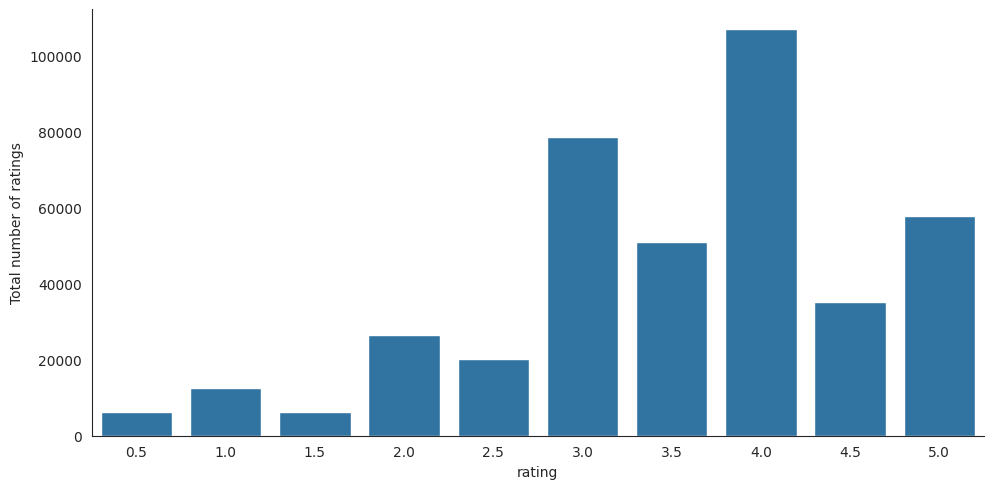

In [11]:
with sns.axes_style('white'):
    g = sns.catplot(data=df_train, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(df_train["rating"])}')

In [28]:
merged_df = pd.merge(df_movies, df_imdb_data, on='movieId')

final_df = merged_df[['movieId', 'title', 'title_cast', 'genres', 'director', 'runtime', 'budget',	'plot_keywords']]

final_df.head()

,movieId,title,title_cast,genres,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Adventure|Children|Fantasy,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Comedy|Romance,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Whitney Houston|Angela Bassett|Loretta Devine|...,Comedy|Drama|Romance,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...,Comedy,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [30]:
final_df['director_titlecast'] = (pd.Series(final_df[['director', 'title_cast']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

titles = final_df['title']
indices = pd.Series(final_df.index, index=final_df['title'])

In [38]:
indices.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

In [32]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns
tf_movietags_matrix = tf.fit_transform(final_df['director_titlecast'])

In [33]:
cosine_sim_movietags = cosine_similarity(tf_movietags_matrix,
                                        tf_movietags_matrix)
print (cosine_sim_movietags.shape)

(20780, 20780)


In [34]:
cosine_sim_movietags[:5]

array([[1.        , 0.        , 0.00484998, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.0025669 , ..., 0.        , 0.        ,
        0.        ],
       [0.00484998, 0.0025669 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01654376, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00467001, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [41]:
def content_generate_top_N_recommendations(movie_title, N=10):
    # Convert the string book title to a numeric index for our
    # similarity matrix
    b_idx = indices[movie_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_movietags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles
    return titles.iloc[book_indices]

In [42]:
content_generate_top_N_recommendations("Toy Story (1995)", N=10)

3020                                    Toy Story 2 (1999)
14758                                   Toy Story 3 (2010)
20294                           Toy Story of Terror (2013)
10314    After School Special (a.k.a. Barely Legal) (2003)
20452                                 Tim's Vermeer (2013)
5769                                Treasure Planet (2002)
18072                                    Chimpanzee (2012)
4779                                 Monsters, Inc. (2001)
13909                                       Top Dog (1995)
Name: title, dtype: object